In [2]:
%matplotlib inline
import pandas as pd
import torch
import random
from d2l import torch as d2l

In [3]:
def synthetic_data(w,b,num_examples):#@save
    """生成y=wx+b噪声"""
    x=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(x,w)+b#2-dimension，2维以上，要用torch.matmul,矩阵向量乘还是矩阵矩阵乘
    y=y+torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))

In [4]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,10000)

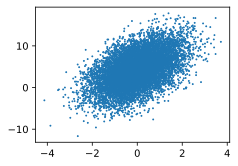

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:,0].detach(),labels.detach(),1);

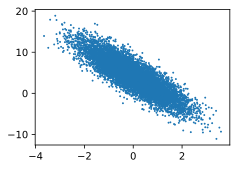

In [5]:
d2l.plt.scatter(features[:,1].detach(),labels.detach(),1);

###  可以发现，features的第一维和第二维，分别都与labels呈现出强烈的线性关系

# 3.2.2 读取数据集：


### 定义一个data_iter函数，用来读入批量大小，特征矩阵和标签向量，生成batch_size小批量，包含有特征和标签

#### 注意yield迭代器的使用，十分重要

In [6]:
def data_iter(batch_size,feature,label):
    num_sample=len(feature)
    indice=list(range(num_sample))
    random.shuffle(indice)
    for i in range(0,num_sample,batch_size):
        batch_indice=torch.tensor(indice[i:min(i+batch_size,num_sample)])
        yield feature[batch_indice],labels[batch_indice]

In [7]:
batch_size=10
for x,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break

tensor([[ 0.3808, -0.7349],
        [-0.6977,  0.4638],
        [-1.2146, -1.5224],
        [ 0.5202, -0.7194],
        [-0.4262,  0.0260],
        [ 0.3758,  0.4156],
        [ 0.0069, -1.2989],
        [ 0.8758, -2.4144],
        [-0.6786, -0.2043],
        [ 0.2296, -0.1105]]) 
 tensor([[ 7.4574],
        [ 1.2271],
        [ 6.9479],
        [ 7.6916],
        [ 3.2601],
        [ 3.5508],
        [ 8.6287],
        [14.1499],
        [ 3.5445],
        [ 5.0459]])


In [8]:
w=torch.normal(0,2,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
w,b

(tensor([[-1.2215],
         [ 2.5505]], requires_grad=True),
 tensor([0.], requires_grad=True))

#### 定义线性模型

In [10]:
def linreg(x,w,b):#@save
    """定义线性模型"""
    return torch.matmul(x,w)+b

In [11]:
def squared_loss(y_hat,y_real):#@save
    '''定义损失函数'''
    return (y_hat-y_real.reshape(y_hat.shape))**2/2

In [12]:
def sgd(params,lr,batch_size):#@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

#### 迭代过程

In [13]:
lr=0.03
num_epochs=6
net=linreg
loss=squared_loss
"""电脑性能过于好，迭代几次就出结果"""
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        l=loss(net(x,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch={epoch+1},loss={float(train_l.mean()):.5f}')

epoch=1,loss=0.00005
epoch=2,loss=0.00005
epoch=3,loss=0.00005
epoch=4,loss=0.00005
epoch=5,loss=0.00005
epoch=6,loss=0.00005


In [38]:
print(f'w的估计误差:{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b-b}')

w的估计误差:tensor([ 0.0001, -0.0010], grad_fn=<SubBackward0>)
b的估计误差:tensor([-0.0002], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现：（调包）

In [51]:
import numpy as np
import pandas as pd
import torch
from d2l import torch as d2l
from torch.utils import data

true_w=torch.tensor([2,-3.4])
true_b=torch.tensor(4.2)
features,labels=synthetic_data(true_w,true_b,1000)

##### 构造pytorch数据迭代器

In [54]:
def load_array(data_arrays,batch_size,is_train=True):#迭代器
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)

next(iter(data_iter))

[tensor([[ 0.7375,  0.7939],
         [ 0.7231,  0.2529],
         [-0.3771,  0.8320],
         [-1.5187, -0.5819],
         [-0.9369, -1.6534],
         [ 0.8716,  0.4140],
         [-0.9323,  0.5706],
         [-0.1065, -0.6747],
         [ 0.2690,  0.7503],
         [ 0.2387, -0.4022]]),
 tensor([[2.9685],
         [4.7859],
         [0.5976],
         [3.1521],
         [7.9483],
         [4.5247],
         [0.4024],
         [6.2877],
         [2.1803],
         [6.0357]])]

##### 使用nn.sequential 来定义模型:

In [71]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

In [72]:
net[0].weight.data.normal_(0,4)
net[0].bias.data.fill_(0)
"""使用weight.data,bias.data来访问网络参数"""

'使用weight.data,bias.data来访问网络参数'

In [73]:
loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

In [97]:
num_epoches=6
for epoch in range(num_epoches):
    for x,y in data_iter:
        l=loss(net(x),y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
    train_loss=loss(net(features),labels)
    print(f'epoch={epoch+1},loss={train_loss:.9f}')

epoch=1,loss=0.000102433
epoch=2,loss=0.000101975
epoch=3,loss=0.000102285
epoch=4,loss=0.000101951
epoch=5,loss=0.000101805
epoch=6,loss=0.000102442


#### 比较真实参数和模型参数之间的误差

In [98]:
w=net[0].weight.data#访问网络参数
b=net[0].bias.data
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)},b的估计误差：{true_b-b}')

w的估计误差：tensor([0.0009, 0.0005]),b的估计误差：tensor([0.0004])
